### SINGLE NEURON SYSTEM ###

## definiamo il modello ##

useremo il modello Hodgkin-Huxley.

# variabili #
- V: potenziale di membrana
- m,h,n: variabili di gating che regolano la probabilità di apertura dei canali

# costanti #
- Cm: capacità della membrana
- GNa: massima conduttanza dei canali di sodio
- GK: massima conduttanza dei canali di potassio
- GL: massima conduttanza dei canali leak
- ENa: potenziale inverso per il sodio (V di equilibrio per il flusso di sodio attraverso la membrana)
- EK: potenziale inverso per il potassio (V di equilibrio per il flusso di potassio attraverso la membrana)
- EL: potenziale inverso per i canali leak (V di equilibrio per il flusso di leak attraverso la membrana) 
- Iext: inpulso di corrente esterno lo considero una funzione del tempo

# funzioni del modello #
dV_dt = Iext-INa(V)-IK(V,n)-IL(V) / Cm                                     
dn_dt = n_inf(V) - n / tau_n

# funzini ausiliarie #
alpha_m(V) = (0.1*(25-V))/(e^((25-v)/10)-1)           beta_m = 4*e^(-V/18)                  
alpha_n(V) = (0.1*(10-V))/(e^((10-v)/10)-1)           beta_n = 0.125*e^(-V/80) 
aplha_h(V) = 0.07*e^(-V/20)                           beta_h = 1/(1+e^((30-V)/10))

n_inf = alpha_n(V)/(alpha_n(V) + beta_n(V))  n_inf = 1 / (1 + e^(-(V - V_mid_n)/k_n))               
m_inf = alpha_m(V)/(alpha_m(V) + beta_m(V))  m_inf = 1 / (1 + e^(-(V - V_mid_m)/k_m))              
Tau_n = 1/(alpha_n(V) + beta_n(V))

INa = GNa * m_inf(V) * (V - ENa)         
IK = GK * n * (V - EK)            
IL = GL * (V - EL)

# calcolo degli equilibri #
per trovare gli equilibri devo trovare i punti nelle quali le derivate si annullano contemporaneamente.
risolvendo il sistema troverò gli equilibri

# stabiltà #
per vedere la stabilità degli equilibri devo andare a controllare la jacobiana. Se tutti gli autovalori sono negativi significa che
le derivate per ogni variabile sono decrescenti intorno all'equilibrio e quindi abbiamo un bacino di attrazzione.
 

In [99]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
from scipy.linalg import eigvals 
import matplotlib.gridspec as gridspec

# Parametri del modello Hodgkin-Huxley
C_m = 1.0       # Capacità della membrana (uF/cm^2)
g_Na = 120.0    # Conduttanza massima del sodio (mS/cm^2)
g_K = 36.0      # Conduttanza massima del potassio (mS/cm^2)
g_L = 0.3       # Conduttanza della perdita (mS/cm^2)
E_Na = 50.0     # Potenziale di equilibrio del sodio (mV)
E_K = -77.0     # Potenziale di equilibrio del potassio (mV)
E_L = -54.4     # Potenziale di equilibrio della perdita (mV)
I_ext = 8.0    # Corrente esterna (uA/cm^2)

# Funzioni per il modello Hodgkin-Huxley
# Funzioni numericamente stabili per alpha e beta
def alpha_m(V):
    if V == -40:
        return 0.1 / 10  # Limite per evitare divisione per zero
    else:
        return 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10))

def beta_m(V):
    return 4.0 * np.exp(-(V + 65) / 18)

def alpha_h(V):
    return 0.07 * np.exp(-(V + 65) / 20)

def beta_h(V):
    return 1 / (1 + np.exp(-(V + 35) / 10))

def alpha_n(V):
    if V == -55:
        return 0.01 / 10  # Limite per evitare divisione per zero
    else:
        return 0.01 * (V + 55) / (1 - np.exp(-(V + 55) / 10))

def beta_n(V):
    return 0.125 * np.exp(-(V + 65) / 80)

def dalpha_m_dV(V):
    return (0.1 * (1 - np.exp(-(V + 40) / 10) - (V + 40) * np.exp(-(V + 40) / 10) / 10)) / (1 - np.exp(-(V + 40) / 10))**2

def dbeta_m_dV(V):
    return -4 * 0.0556 * np.exp(-0.0556 * (V + 65))

def dalpha_h_dV(V):
    return -0.07 * 0.05 * np.exp(-0.05 * (V + 65))

def dbeta_h_dV(V):
    return +0.1 * np.exp(-0.1 * (V + 35)) / (1 + np.exp(-0.1 * (V + 35)))**2

def dalpha_n_dV(V):
    return (0.01 * (1 - np.exp(-(V + 55) / 10) - (V + 55) * np.exp(-(V + 55) / 10) / 10)) / (1 - np.exp(-(V + 55) / 10))**2

def dbeta_n_dV(V):
    return -0.125 / 80 * np.exp(-(V + 65) / 80)

def I_ext_f(t,Ie):
    if isinstance(Ie, list):
        return sum(valore * (t_start <= t < t_start + durata) for valore, t_start, durata in Ie)
    return Ie
# Funzione dinamica del modello
def hodgkin_huxley(t, y, Ie):
    V, m, h, n = y
    I_Na = g_Na * (m**3) * h * (V - E_Na)
    I_K = g_K * (n**4) * (V - E_K)
    I_L = g_L * (V - E_L)
    dVdt = (I_ext_f(t,Ie) - I_Na - I_K - I_L) / C_m
    dmdt = alpha_m(V) * (1 - m) - beta_m(V) * m
    dhdt = alpha_h(V) * (1 - h) - beta_h(V) * h
    dndt = alpha_n(V) * (1 - n) - beta_n(V) * n
    return [dVdt, dmdt, dhdt, dndt]

def time_phase_plot(V0,T,n_p, I_ext):
    # Potenziale di riposo (mV)
    m0 = alpha_m(V0) / (alpha_m(V0) + beta_m(V0))
    h0 = alpha_h(V0) / (alpha_h(V0) + beta_h(V0))
    n0 = alpha_n(V0) / (alpha_n(V0) + beta_n(V0))
    y0 = [V0, m0, h0, n0]

    # Intervallo di tempo
    t_span = [0, T]  # Tempo totale di simulazione (ms)
    t_eval = np.linspace(t_span[0], t_span[1], n_p)

    # Risoluzione numerica del sistema
    sol = solve_ivp(hodgkin_huxley, t_span, y0, args=(I_ext,),t_eval=t_eval, method="RK45")

    # Estrazione delle soluzioni
    V = sol.y[0]
    m = sol.y[1]
    h = sol.y[2]
    n = sol.y[3]
    t = sol.t

    # Grafici delle variabili nel tempo
    plt.figure(figsize=(12, 8))
    plt.subplot(3, 1, 1)
    plt.plot(t, V, label="V (mV)")
    plt.title("Dinamica del potenziale di membrana")
    plt.xlabel("Tempo (ms)")
    plt.ylabel("Potenziale (mV)")
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(t, m, label="m (Gate Na)", color="red")
    plt.plot(t, h, label="h (Gate Na)", color="blue")
    plt.plot(t, n, label="n (Gate K)", color="green")
    plt.title("Dinamica delle variabili di gating")
    plt.xlabel("Tempo (ms)")
    plt.ylabel("Apertura dei canali")
    plt.legend()

    plt.tight_layout()
    plt.show()

    t_span = [0, 10*T]  # Tempo totale di simulazione (ms)
    t_eval = np.linspace(t_span[0], t_span[1], 10*n_p)
    sol = solve_ivp(hodgkin_huxley, t_span, y0, args=(I_ext,), t_eval=t_eval, method="RK45")
    V = sol.y[0]
    m = sol.y[1]
    h = sol.y[2]
    n = sol.y[3]
    t = sol.t

    # Grafici di fase per (V, n), (V, m) e (V, h)
    fig = plt.figure(figsize=(18, 6))
    gs = gridspec.GridSpec(1,3)

    ax1 = fig.add_subplot(gs[0,0])
    ax1.plot(n, V, label="Traiettoria nel piano (V, n)", color="green")
    ax1.set_ylabel("Potenziale di membrana V (mV)")
    ax1.set_xlabel("n (Gate K)")
    ax1.legend()
    ax1.grid()

    ax2 = fig.add_subplot(gs[0,1])
    ax2.plot(m, V, label="Traiettoria nel piano (V, m)", color="red")
    ax2.set_ylabel("Potenziale di membrana V (mV)")
    ax2.set_xlabel("m (Gate Na)")
    ax2.legend()
    ax2.grid()

    ax3 = fig.add_subplot(gs[0,2])
    ax3.plot(h, V, label="Traiettoria nel piano (V, h)", color="blue")
    ax3.set_ylabel("Potenziale di membrana V (mV)")
    ax3.set_xlabel("h (Gate Na)")
    ax3.legend()
    ax3.grid()

    plt.tight_layout()
    plt.show()

# Analisi della stabilità degli equilibri
def steady_state(y,I_ext):
    return hodgkin_huxley(0, y,I_ext)

# Ricerca degli equilibri
def equilibrium_study(V0,T,n_p,I_range, n_I):
    m0 = alpha_m(V0) / (alpha_m(V0) + beta_m(V0))
    h0 = alpha_h(V0) / (alpha_h(V0) + beta_h(V0))
    n0 = alpha_n(V0) / (alpha_n(V0) + beta_n(V0))
    y0 = [V0, m0, h0, n0]

    # Intervallo di tempo
    t_span = [0, T]  # Tempo totale di simulazione (ms)
    t_eval = np.linspace(t_span[0], t_span[1], n_p)

    # Cicli limite e multistabilità
    I_ext_values = np.linspace(I_range[0], I_range[1] , n_I)
    limit_cycles = []


    for I in I_ext_values:
        equilibrium, info, ier, msg = fsolve(steady_state, y0, args=(I,), full_output=True)
        J = info['fjac']
        eigenvalues = eigvals(J)
        stabile = all(np.real(eig) < 0 for eig in eigenvalues)
        if stabile:
            print(f'Equilibrio stabile trovato: {equilibrium}. Per corrente: {I} μA/cm²')
        else:
            print(f'Equilibrio instabile trovato: {equilibrium}. Per corrente: {I} μA/cm²')
        
        sol = solve_ivp(hodgkin_huxley, t_span, y0, args= (I,),t_eval=t_eval, method="RK45")
        limit_cycles.append((I, sol.y[0]))

    # Plot cicli limite
    plt.figure(figsize=(10, 4))
    for I, V in limit_cycles:
        plt.plot(t_eval, V, label=f"I_ext = {I} μA/cm²")
    plt.title("Cicli limite per diversi valori di I_ext")
    plt.xlabel("Tempo (ms)")
    plt.ylabel("Potenziale di membrana (mV)")
    plt.legend(loc= 1)
    plt.show()

def biforcation_plot(V0, T, n_p, I_range, n_I):
    m0 = alpha_m(V0) / (alpha_m(V0) + beta_m(V0))
    h0 = alpha_h(V0) / (alpha_h(V0) + beta_h(V0))
    n0 = alpha_n(V0) / (alpha_n(V0) + beta_n(V0))
    y0 = [V0, m0, h0, n0]

    I_ext_values = np.linspace(0, I_range, n_I)
    V_stable, V_unstable = [], []

    def jacobian(V, m, h, n):
        dV_dV = -g_Na * m**3 * h - g_K * n**4 - g_L
        dV_dm = -3 * g_Na * m**2 * h * (V - E_Na)
        dV_dh = -g_Na * m**3 * (V - E_Na)
        dV_dn = -4 * g_K * n**3 * (V - E_K)
        dm_dV = dalpha_m_dV(V)*(1-m) - dbeta_m_dV(V)*m
        dh_dV = dalpha_h_dV(V)*(1-h) - dbeta_h_dV(V)*h
        dn_dV = dalpha_n_dV(V)*(1-n) - dbeta_n_dV(V)*n
        return np.array([
            [dV_dV, dV_dm, dV_dh, dV_dn],
            [dm_dV, -alpha_m(V) - beta_m(V), 0, 0],
            [dh_dV, 0, -alpha_h(V) - beta_h(V), 0],
            [dn_dV, 0, 0, -alpha_n(V) - beta_n(V)]
        ])
    # Calcolo degli equilibri e della loro stabilità
    for I_ext in I_ext_values:
        sol= solve_ivp(hodgkin_huxley, [0,T], y0, args=(I_ext,), t_eval=[n_p])
        V, m, h, n = sol.y[:, -1]
        J = jacobian(V,m,h,n)
        eigenvalues = eigvals(J)
        if np.all(np.real(eigenvalues) < 0):  # Stabilità: tutti gli autovalori hanno parte reale negativa
            V_stable.append((I_ext, V))
        else:
            V_unstable.append((I_ext, V))

    # Separazione degli equilibri stabili e instabili per il grafico
    V_stable = np.array(V_stable)
    V_unstable = np.array(V_unstable)

    # Plot del diagramma di biforcazione con stabilità
    plt.figure(figsize=(10, 6))
    if V_stable.size > 0:
        plt.plot(V_stable[:, 0], V_stable[:, 1], 'b.', markersize=4, label="Equilibri stabili")
    if V_unstable.size > 0:
        plt.plot(V_unstable[:, 0], V_unstable[:, 1], 'r^', markersize=4, label="Equilibri instabili")
    plt.xlabel("Corrente esterna $I_{ext}$ (μA/cm²)")
    plt.ylabel("Potenziale di membrana $V$ (mV)")
    plt.title("Diagramma di biforcazione con equilibri stabili e instabili (Hodgkin-Huxley)")
    plt.legend()
    plt.grid()
    plt.show()

# Regular Spiking #
Descrizione: Con uno stimolo continuo sopra la soglia, il neurone produce una serie di potenziali d’azione con una frequenza regolare.       
Dinamica: La frequenza aumenta all’aumentare della corrente esterna (Ie).         
Condizioni: Corrente costante di intensità moderata-alta.         
Ruolo funzionale: Trasmissione di segnali persistenti.      

C:\Users\pitom\AppData\Local\Temp\ipykernel_16024\133604675.py:24: RuntimeWarning: overflow encountered in exp
  return 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10))
C:\Users\pitom\AppData\Local\Temp\ipykernel_16024\133604675.py:33: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-(V + 35) / 10))
C:\Users\pitom\AppData\Local\Temp\ipykernel_16024\133604675.py:39: RuntimeWarning: overflow encountered in exp
  return 0.01 * (V + 55) / (1 - np.exp(-(V + 55) / 10))
C:\Users\pitom\AppData\Local\Temp\ipykernel_16024\133604675.py:27: RuntimeWarning: overflow encountered in exp
  return 4.0 * np.exp(-(V + 65) / 18)
C:\Users\pitom\AppData\Local\Temp\ipykernel_16024\133604675.py:30: RuntimeWarning: overflow encountered in exp
  return 0.07 * np.exp(-(V + 65) / 20)
C:\Users\pitom\AppData\Local\Temp\ipykernel_16024\133604675.py:42: RuntimeWarning: overflow encountered in exp
  return 0.125 * np.exp(-(V + 65) / 80)


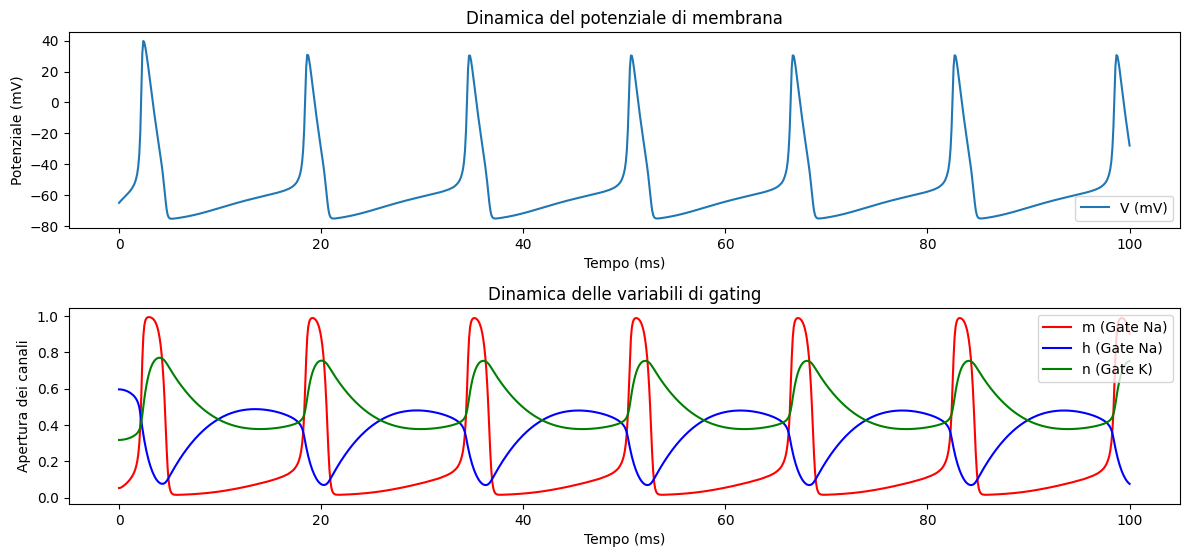

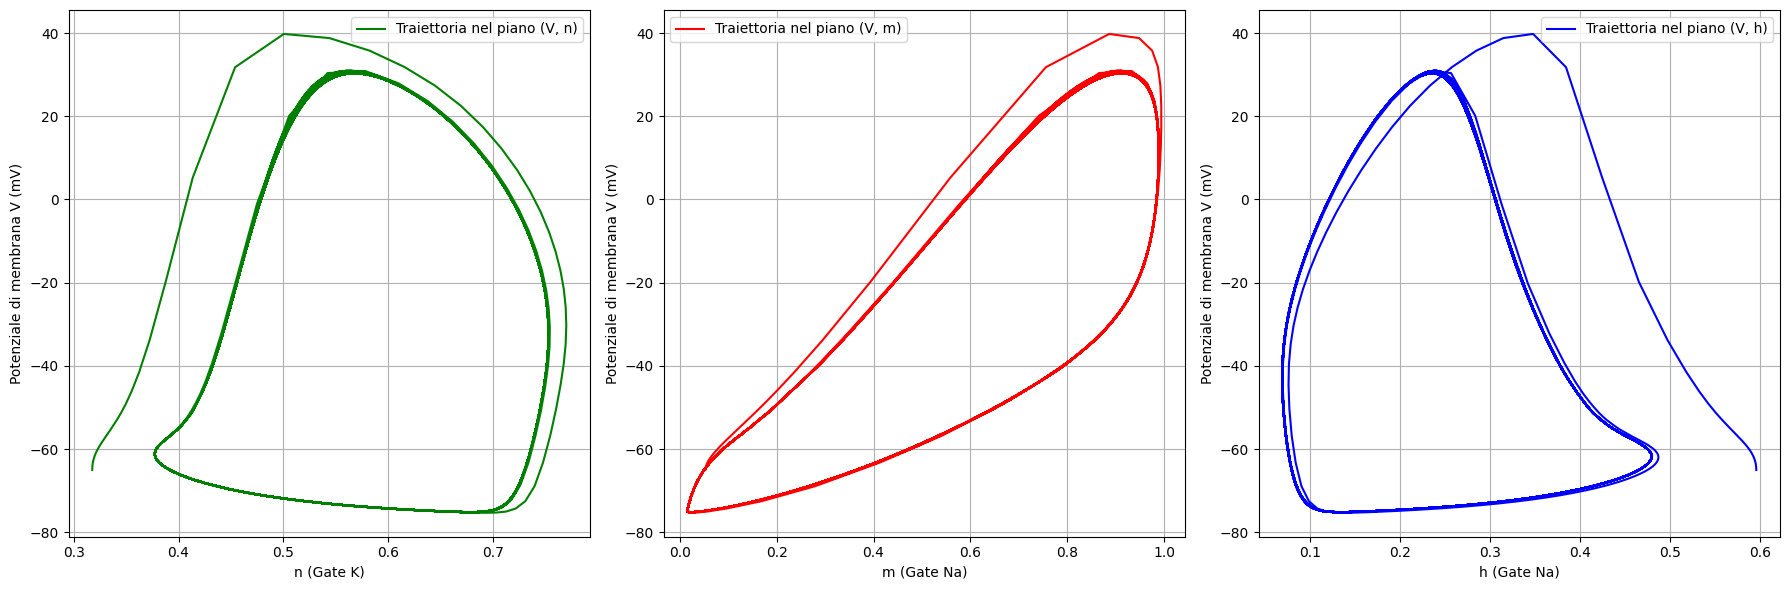

In [100]:
I_ext = 8
time_phase_plot(-65,100,1000,I_ext)

# Resting State #
Descrizione: Il neurone si trova a un potenziale di membrana stabile, di solito vicino al valore di equilibrio del potenziale di riposo.          
Correnti dominanti: La corrente del potassio (IK) bilancia le piccole correnti di sodio (INa) e quella di perdita (IL).         
Condizioni: Si verifica quando la corrente esterna (Ie) è assente o troppo bassa per superare la soglia.        
Dinamica: Non si verificano oscillazioni o attività spontanea.

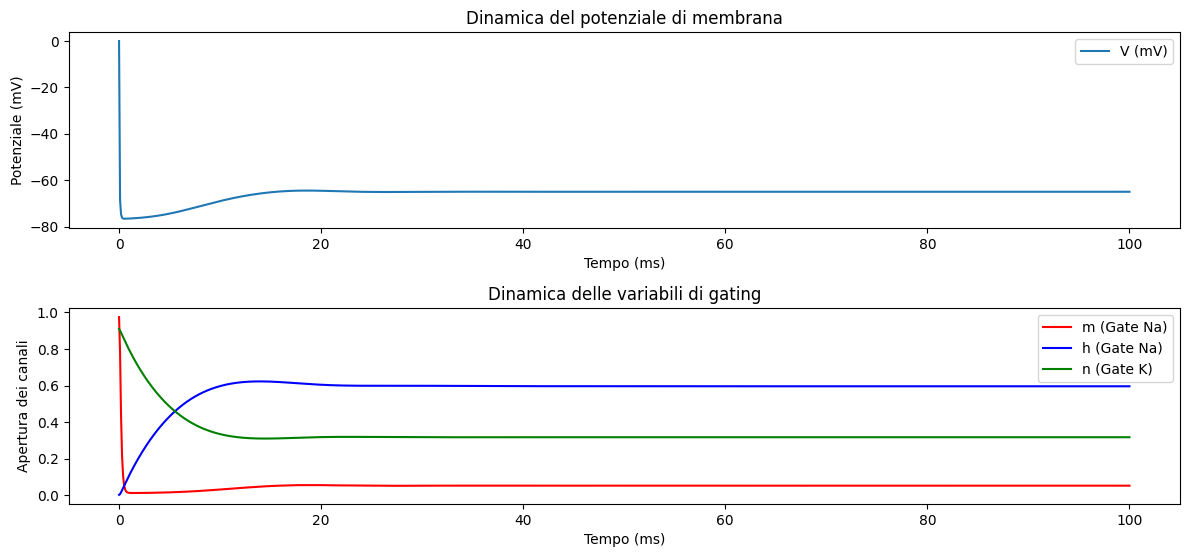

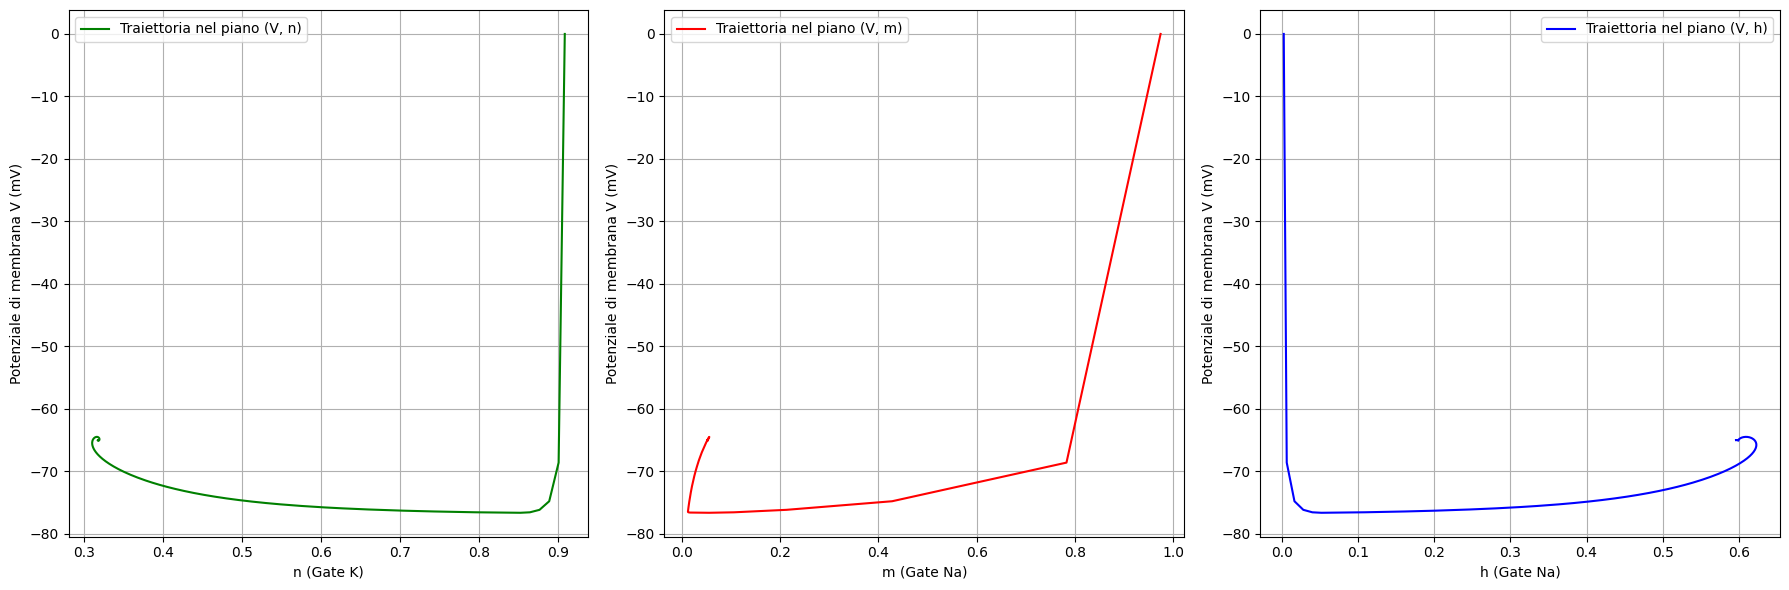

In [101]:
I_ext = 0
time_phase_plot(0,100,1000,I_ext)

# Subthreshold Response #
Descrizione: Piccole depolarizzazioni del potenziale di membrana che non superano la soglia di attivazione.       
Correnti dominanti: Le correnti passive (e.g., perdite) e una leggera attivazione delle correnti di sodio.     
Condizioni: Stimoli esterni (Ie) che non sono sufficientemente forti per generare un potenziale d'azione.          
Dinamica: Il neurone ritorna al potenziale di riposo senza attività significativa.      


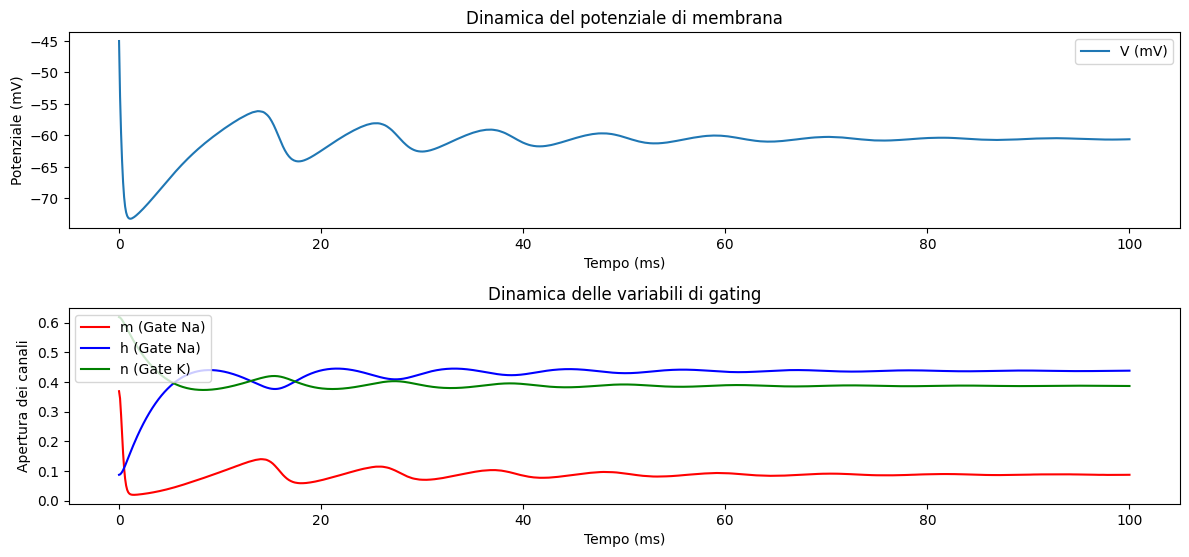

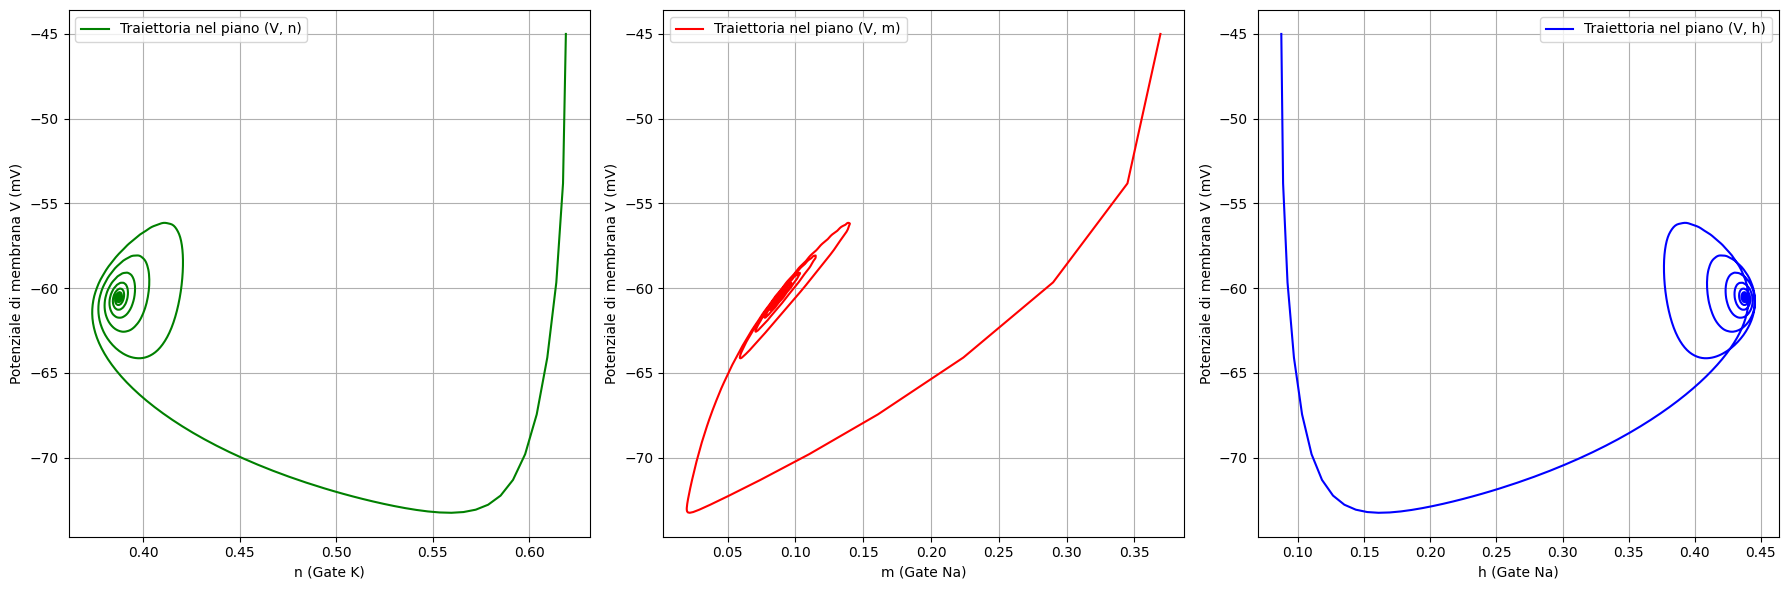

In [109]:
I_ext = 7.5
time_phase_plot(-45,100,1000,I_ext)

# Spiking #
Descrizione: Se lo stimolo esterno (Ie) supera una soglia critica, il neurone genera un potenziale d’azione.       
Fasi del potenziale d’azione:                                                                                           
    Depolarizzazione rapida: Apertura dei canali del sodio (m aumenta), con un forte flusso di Na+ verso l'interno.        
    Ripolarizzazione: Apertura dei canali del potassio (n aumenta) e inattivazione dei canali del sodio (h diminuisce).       
    Iperpolarizzazione: Il potenziale scende al di sotto del potenziale di riposo per breve tempo.          
Correnti dominanti: Transizioni rapide tra INa (sodio) e IK (potassio).          
Condizioni: Stimoli esterni (Ie) sufficienti a superare la soglia         

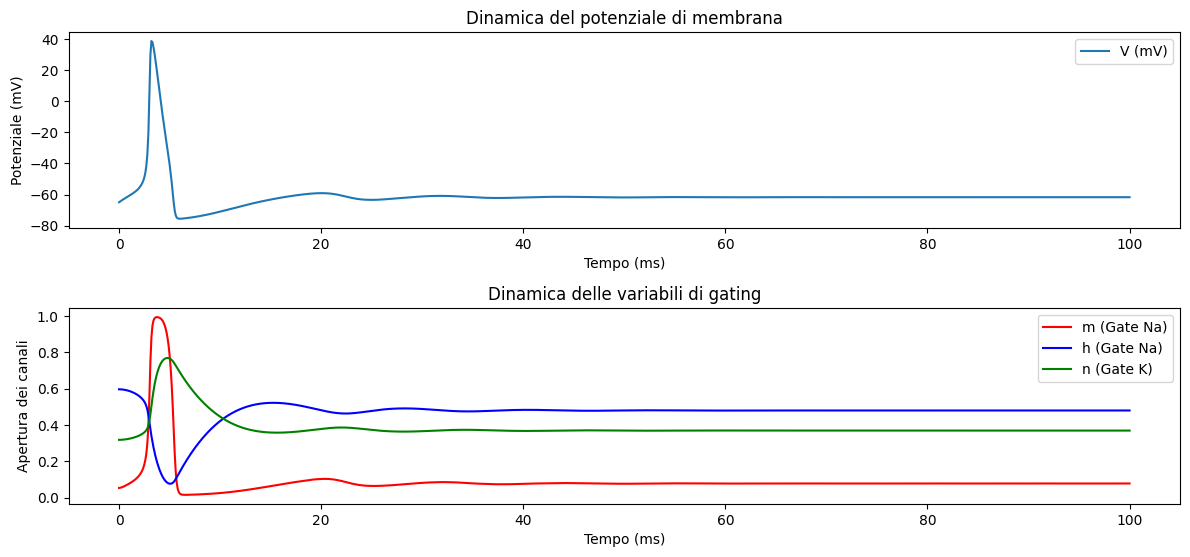

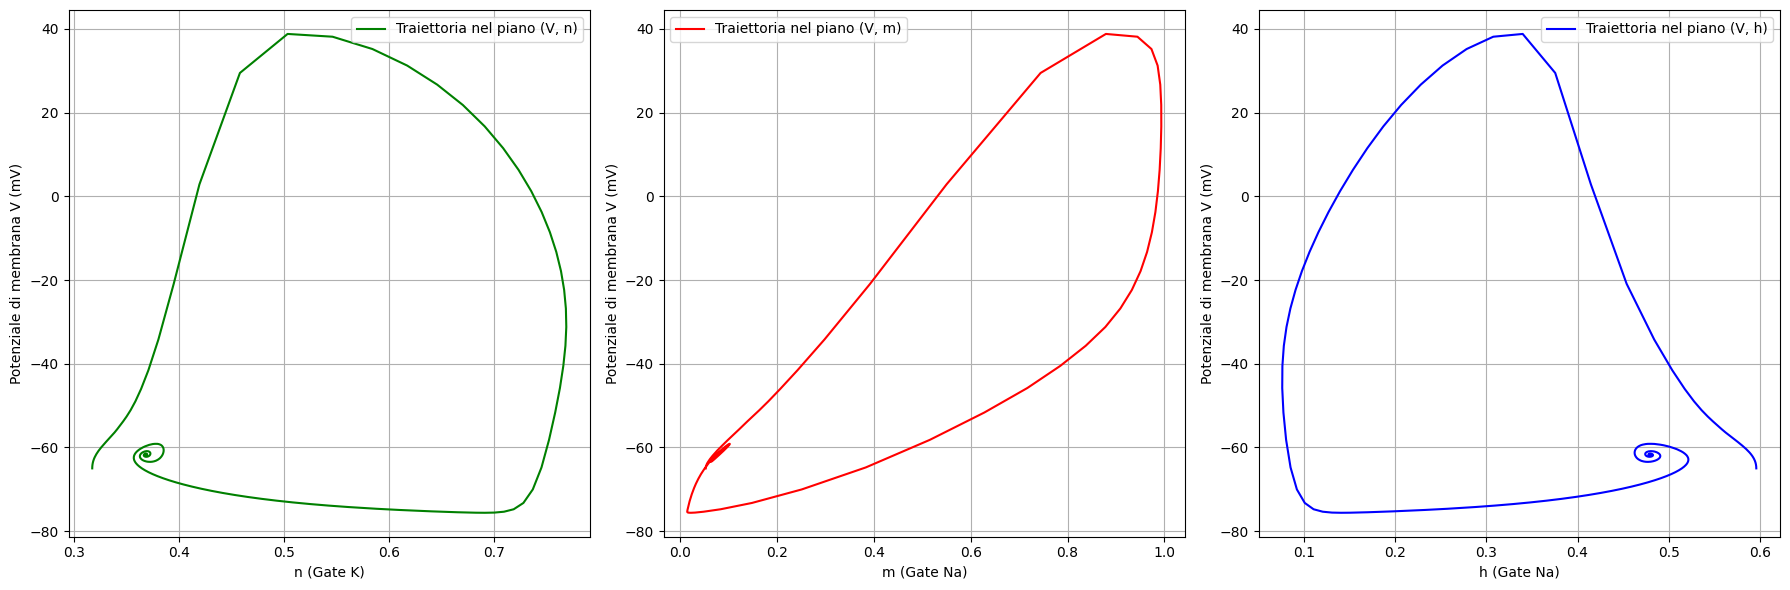

In [116]:
I_ext = 5
time_phase_plot(-65,100,1000,I_ext)

# Bursting #
Descrizione: Attività in cui il neurone genera brevi raffiche di potenziali d’azione seguite da periodi di silenzio.                             
Correnti dominanti: Può dipendere da una combinazione di INa, IK e correnti lente (come ICa nel caso di estensioni del modello Hodgkin-Huxley).              
Condizioni: Stimoli variabili o dinamiche interne al neurone.                
Ruolo funzionale: Segnali più complessi utilizzati, ad esempio, in reti neurali per funzioni motorie o cognitive.

# Comportamento Caotico #
Descrizione: In specifiche condizioni (ad esempio, modifiche nei parametri del sistema), il neurone può mostrare dinamiche caotiche.       
Correnti dominanti: Interazione complessa tra tutte le correnti ioniche.           
Condizioni: Può verificarsi in modelli estesi o con stimoli irregolari.                  
Ruolo funzionale: Potenziale per spiegare attività neurale complessa e imprevedibile.        

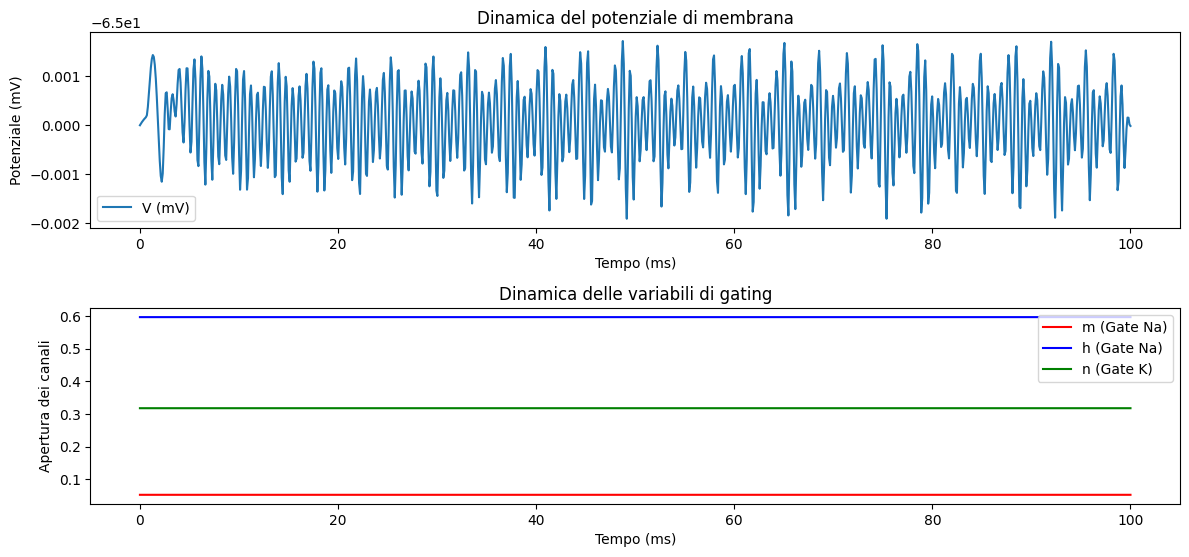

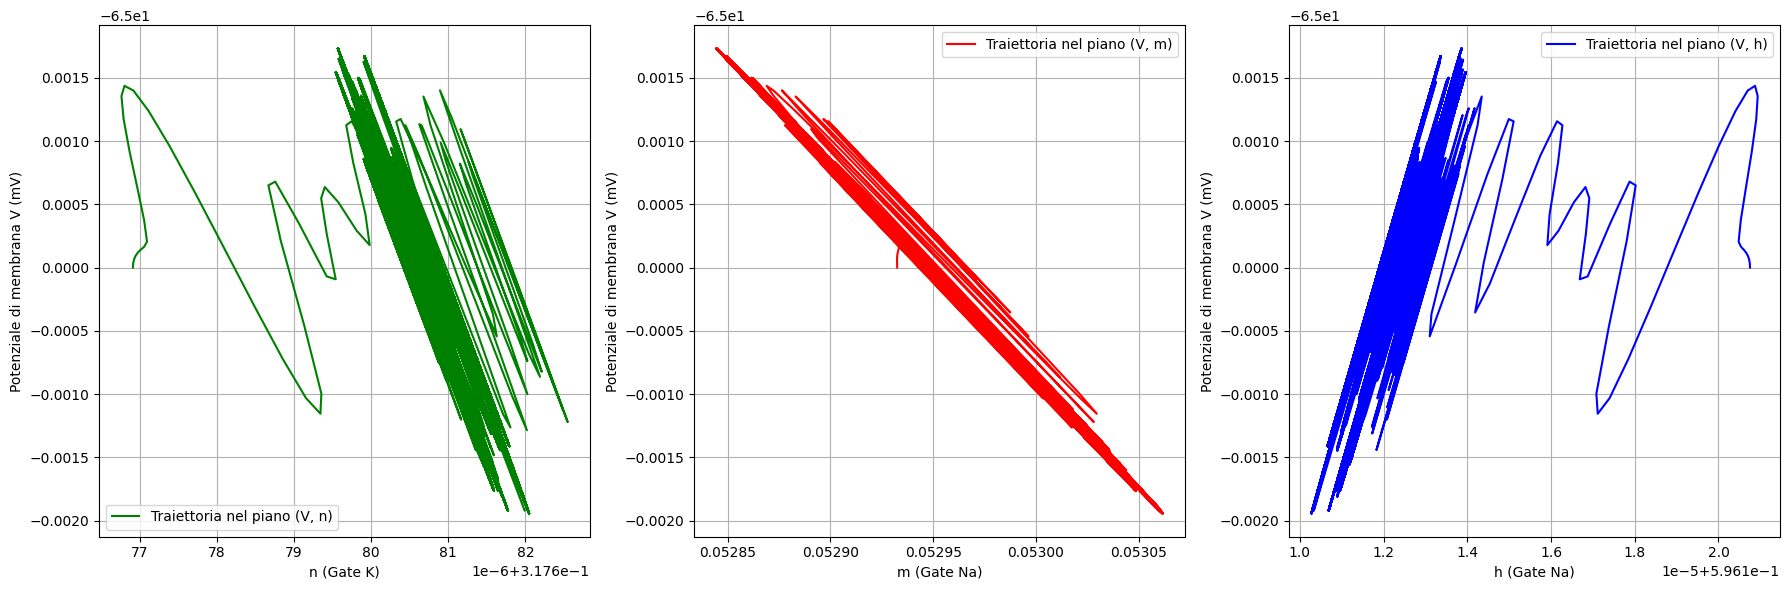

In [117]:
I_ext = 0
time_phase_plot(-65,100,1000,I_ext)

Equilibrio stabile trovato: [-6.49997224e+01  5.29342176e-02  5.96111046e-01  3.17681168e-01]. Per corrente: 0.0 μA/cm²
Equilibrio stabile trovato: [-63.15744763   0.06561803   0.53058528   0.34625123]. Per corrente: 2.5 μA/cm²
Equilibrio stabile trovato: [-61.73312735   0.07719744   0.47937531   0.36870352]. Per corrente: 5.0 μA/cm²
Equilibrio stabile trovato: [-60.56573267   0.08797322   0.43789942   0.38725252]. Per corrente: 7.5 μA/cm²
Equilibrio instabile trovato: [-59.57203005   0.09813275   0.40341539   0.40309395]. Per corrente: 10.0 μA/cm²


C:\Users\pitom\AppData\Local\Temp\ipykernel_16024\133604675.py:24: RuntimeWarning: overflow encountered in exp
  return 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10))
C:\Users\pitom\AppData\Local\Temp\ipykernel_16024\133604675.py:27: RuntimeWarning: overflow encountered in exp
  return 4.0 * np.exp(-(V + 65) / 18)
C:\Users\pitom\AppData\Local\Temp\ipykernel_16024\133604675.py:30: RuntimeWarning: overflow encountered in exp
  return 0.07 * np.exp(-(V + 65) / 20)
C:\Users\pitom\AppData\Local\Temp\ipykernel_16024\133604675.py:33: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-(V + 35) / 10))
C:\Users\pitom\AppData\Local\Temp\ipykernel_16024\133604675.py:39: RuntimeWarning: overflow encountered in exp
  return 0.01 * (V + 55) / (1 - np.exp(-(V + 55) / 10))
C:\Users\pitom\AppData\Local\Temp\ipykernel_16024\133604675.py:42: RuntimeWarning: overflow encountered in exp
  return 0.125 * np.exp(-(V + 65) / 80)


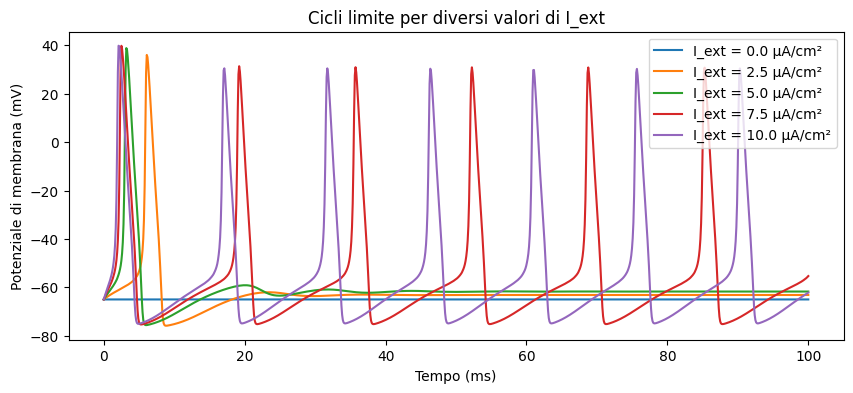

C:\Users\pitom\AppData\Local\Temp\ipykernel_16024\133604675.py:69: RuntimeWarning: overflow encountered in scalar power
  I_Na = g_Na * (m**3) * h * (V - E_Na)
C:\Users\pitom\AppData\Local\Temp\ipykernel_16024\133604675.py:72: RuntimeWarning: invalid value encountered in scalar subtract
  dVdt = (I_ext_f(t,Ie) - I_Na - I_K - I_L) / C_m
C:\Users\pitom\AppData\Local\Temp\ipykernel_16024\133604675.py:73: RuntimeWarning: invalid value encountered in scalar multiply
  dmdt = alpha_m(V) * (1 - m) - beta_m(V) * m
C:\Users\pitom\AppData\Local\Temp\ipykernel_16024\133604675.py:74: RuntimeWarning: invalid value encountered in scalar multiply
  dhdt = alpha_h(V) * (1 - h) - beta_h(V) * h
C:\Users\pitom\AppData\Local\Temp\ipykernel_16024\133604675.py:75: RuntimeWarning: invalid value encountered in scalar multiply
  dndt = alpha_n(V) * (1 - n) - beta_n(V) * n
C:\Users\pitom\AppData\Local\Temp\ipykernel_16024\133604675.py:70: RuntimeWarning: overflow encountered in scalar power
  I_K = g_K * (n**4)

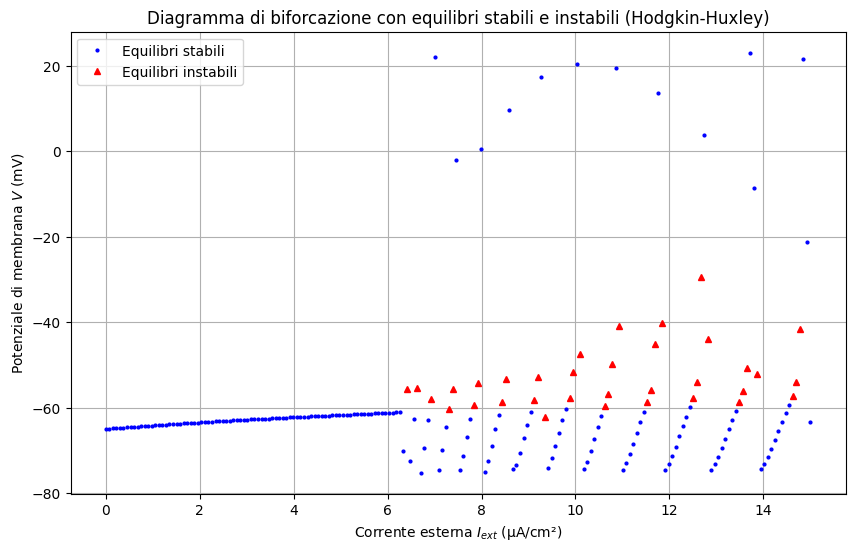

In [118]:
equilibrium_study(-65,100,1000,[0,10],5)
biforcation_plot(-65, 500, 500, 15, 200 )